In [90]:
import os, sys
sys.path.append('/home/oleg/Prog/Science/ship_tracks_recognition/functions')

In [91]:
% matplotlib inline
import pandas
import numpy
import matplotlib.pyplot as plt

# Reading data

In [92]:
all_mctracks = pandas.read_csv('Data/MCTrack.csv', delimiter=',')
all_velo_points = pandas.read_csv('Data/vetoPoint.csv', delimiter=',')
all_hits = pandas.read_csv('Data/strawtubesPoint_decoded_hits.csv', delimiter=',')
all_hits['Index'] = all_hits.index
all_hits = all_hits[['Index', 'X', 'Y', 'Z', 'TrackID', 'Time', 'StatNb', 'ViewNb', 'PlaneNb', 'LayerNb', 'StrawNb', 'dist2Wire', 'event', 'k']]
all_hits.head()

,Index,X,Y,Z,TrackID,Time,StatNb,ViewNb,PlaneNb,LayerNb,StrawNb,dist2Wire,event,k
0,0,8.883409,-61.202305,-1974.859985,3,232.044861,5,0,0,0,319,0.274822,0,0
1,1,8.858191,-61.225544,-1973.742188,3,232.074081,5,0,0,1,320,0.582455,0,1
2,2,8.824563,-61.256523,-1972.251953,3,232.118286,5,0,1,0,319,0.111252,0,2
3,3,8.632817,-61.432972,-1963.756592,3,232.406479,5,1,0,1,320,0.164412,0,3
4,4,8.573978,-61.487133,-1961.149292,3,232.488541,5,1,1,1,320,0.226827,0,4


# Get reconstructible events

In [4]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(2500, 5000):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

/home/oleg/Prog/Science/ship_tracks_recognition/functions/ReconstructibleTracks.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  10000000 * hits.StatNb.values


In [27]:
import cPickle as pickle

rec_ev_file = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/rec_ev_file', 'wb')
pickle.dump(reconstructible_events, rec_ev_file)
rec_ev_file.close()

In [93]:
import cPickle as pickle

rec_ev_file2 = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/rec_ev_file', 'rb')
reconstructible_events = pickle.load(rec_ev_file2)
rec_ev_file2.close()

# Generation Train Data 

In [5]:
from MarginLinearRegression import *
from Y_views import *

In [100]:
def generator(rec_ev, all_hits):
    all_dists = []
    all_scores = []
    all_labels = []
    all_Rs = []
    all_ks = []
    all_bs = []
    inside = []

    for event_id in rec_ev:

        for track_id in [2.0, 3.0]:#reconstructible_events[event_id]:

            event = all_hits[all_hits['event'] == event_id]
            event = modify_for_yz_analysis_1_2(event)

            track = event[event.TrackID == track_id]
            false_track = event[event.TrackID != track_id]

            if len(track) == 0:
                continue

            mixed_track = pandas.concat([track[track.StatNb == 1], false_track[false_track.StatNb == 2]], axis=0)

            if len(track.values) == 0:
                print event_id, track_id
                continue

            if len(false_track.values) == 0:
                print event_id, track_id
                continue

            if len(mixed_track.values) == 0:
                print event_id, track_id
                continue

            pos_labels = [0]*len(track)
            neg_labels = [1]*len(false_track)
            mixed_labels = [2]*len(mixed_track)

            rmlr = RobustMarginLinearRegression(2)
            score, lr = rmlr.fit(track)

            Rs = []
            for i in track.index:
                Rs.append(track.dist2Wire[i])
            false_Rs = []
            for i in false_track.index:
                false_Rs.append(false_track.dist2Wire[i])
            mixed_Rs = []
            for i in mixed_track.index:
                mixed_Rs.append(mixed_track.dist2Wire[i])

            all_Rs += Rs + false_Rs + mixed_Rs

            mixed_rmlr = RobustMarginLinearRegression(2)
            mixed_score, mixed_lr = mixed_rmlr.fit(mixed_track)

            all_scores += [score]*(len(track) + len(false_track)) + [mixed_score]*len(mixed_track)

            inside += [1]*len(track) + [0]*len(false_track) + [1]*len(mixed_track)

            track_dists = rmlr.dist2track(track)[:, 0]
            false_track_dists = rmlr.dist2track(false_track)[:, 0]
            mixed_track_dists = mixed_rmlr.dist2track(mixed_track)[:, 0]

            all_dists += list(track_dists) + list(false_track_dists) + list(mixed_track_dists)
            all_labels += pos_labels + neg_labels + mixed_labels

            all_ks += [lr.coef_[0,0]]*(len(track) + len(false_track)) + [mixed_lr.coef_[0,0]]*(len(mixed_track))
            all_bs += [lr.intercept_[0]]*(len(track) + len(false_track)) + [mixed_lr.intercept_[0]]*(len(mixed_track))
            
    d = pandas.DataFrame()
    d['dist'] = all_dists
    d['score'] = all_scores
    d['score_div_dist'] = d['score'].values / d['dist'].values
    d['slope'] = all_ks
    d['intercept'] = all_bs
    d['label'] = all_labels
    d['r'] = all_Rs
    d['difference'] = np.abs(d['dist'].values-d['r'].values)
    d['quotient'] = d['dist'].values/d['r'].values
    
    return d

In [254]:
data = generator(reconstructible_events)

In [257]:
import cPickle as pickle

data_file = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/data_file', 'wb')
pickle.dump(data, data_file)
data_file.close()

In [6]:
import cPickle as pickle

data_file2 = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/data_file', 'rb')
data = pickle.load(data_file2)
data_file2.close()

# Training Model

In [11]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

X_train, X_test, y_train, y_test = cross_validation.train_test_split(data.drop(['label', 'inside'], 1).values, 
                                                                     data[['label']].values, 
                                                                     test_size = 0.4)

In [175]:
#clf = RandomForestClassifier(n_estimators=1000, 
#                             max_features=None, 
#                             max_depth=6, 
#                             bootstrap=False, 
#                             class_weight='balanced')
clf = GradientBoostingClassifier(n_estimators=1000, 
                                 learning_rate=0.01, 
                                 max_depth=6, 
                                 max_features='auto', 
                                 subsample=0.5, min_samples_split=10)

clf.fit(X_train, y_train)

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier(init=None, learning_rate=0.01, loss='deviance',
              max_depth=6, max_features='auto', max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=0.5, verbose=0,
              warm_start=False)

In [10]:
import cPickle as pickle

clf_pickle = open('classifier.pkl', 'wb')
pickle.dump(clf, clf_pickle)
clf_pickle.close()

In [11]:
import cPickle as pickle

clf_pickle2 = open('classifier.pkl', 'rb')
clf = pickle.load(clf_pickle2)
clf_pickle2.close()

# Get reconstructible events

In [84]:
from ReconstructibleTracks import get_reconstractible_tracks

reconstructible_events = {}

for event_id in range(0, 2000):
    
    tracks = get_reconstractible_tracks(event_id, all_hits, all_mctracks, all_velo_points)
    
    if tracks != []:
        reconstructible_events[event_id] = tracks

/home/oleg/Prog/Science/ship_tracks_recognition/functions/ReconstructibleTracks.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  10000000 * hits.StatNb.values


In [85]:
import cPickle as pickle

rec_ev_file_2 = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/rec_ev_file_2', 'wb')
pickle.dump(reconstructible_events, rec_ev_file_2)
rec_ev_file_2.close()

In [94]:
import cPickle as pickle

rec_ev_file_22 = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/rec_ev_file_2', 'rb')
reconstructible_events_2 = pickle.load(rec_ev_file_22)
rec_ev_file_22.close()

# Generation Test Data

In [92]:
data_test = generator(reconstructible_events_2)

In [96]:
import cPickle as pickle

data_file_2 = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/data_file_2', 'wb')
pickle.dump(data_test, data_file_2)
data_file_2.close()

In [8]:
import cPickle as pickle

data_file_22 = open('/home/oleg/Prog/Science/ship_tracks_recognition/notebooks/Data/data_file_2', 'rb')
data_test = pickle.load(data_file_22)
data_file_22.close()

In [178]:
X_test_test = data_test.drop(['label', 'inside'], 1).values 
y_test_test = data_test[['label']].values

# Test

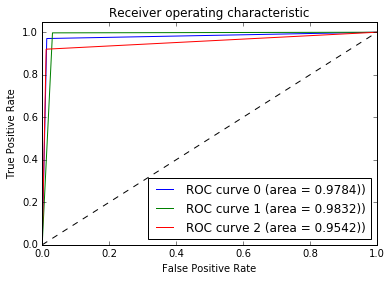

In [179]:
plt.figure()
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.plot([0, 1], [0, 1], 'k--')
y_score = clf.predict(X_test_test)
for i in range(3):
    y_t = y_test_test.reshape(-1)==i
    y_s = y_score==i
    y_t = y_t + [0]*len(y_t)
    y_s = y_s + [0]*len(y_s)
    fpr, tpr, thresholds = metrics.roc_curve(y_t, y_s, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='ROC curve '+str(i)+' (area = %0.4f))' % roc_auc)
plt.legend(loc="lower right")

In [17]:
metrics.recall_score(y_test_test, clf.predict(X_test_test), pos_label=0)

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.96288011184900379

In [18]:
metrics.precision_score(y_test_test, clf.predict(X_test_test), pos_label=0)

/usr/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)


0.96343212366777309

In [19]:
clf.feature_importances_

array([ 0.1583906 ,  0.18369446,  0.26529638,  0.09809365,  0.0663894 ,
        0.02883103,  0.11284655,  0.08645794])

# Error-"ROC AUC" 

In [101]:
def noise(err, l):
    arr = np.random.rand(l) < 0.5
    arr = (arr + [0] * l) * 2 - [1] * l
    arr = arr * err + [1] * l
    return arr

In [102]:
def relation(all_hits, set_err):
    AUC_0 = []
    AUC_1 = []
    AUC_2 = []
    for i in set_err:
        hits = all_hits
        hits['dist2Wire'] = hits['dist2Wire'] * noise(i, len(hits))
        data = generator(reconstructible_events.keys()[:200], hits)
        X_train = data.drop(['label'], 1).values
        y_train = data[['label']].values
        
        clf = GradientBoostingClassifier(n_estimators=1000,
                                         learning_rate=0.01,
                                         max_depth=6,
                                         max_features='auto',
                                         subsample=0.5, min_samples_split=10)

        clf.fit(X_train, y_train)
        data_test = generator(reconstructible_events_2.keys()[:150], hits)
        X_test = data_test.drop(['label'], 1).values 
        y_test = data_test[['label']].values
        
        y_score = clf.predict(X_test)
        for k in range(3):
            y_t = y_test.reshape(-1)==k
            y_s = y_score==k
            y_t = y_t + [0] * len(y_t)
            y_s = y_s + [0] * len(y_s)
            fpr, tpr, thresholds = metrics.roc_curve(y_t, y_s, pos_label=1)
            if k==0:
                AUC_0.append(metrics.auc(fpr, tpr))
            elif k==1:
                AUC_1.append(metrics.auc(fpr, tpr))
            else:
                AUC_2.append(metrics.auc(fpr, tpr))
    return AUC_0, AUC_1, AUC_2

In [103]:
AUC_0, AUC_1, AUC_2 = relation(all_hits, [0.,0.05,0.1,0.2])

/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

In [105]:
AUC_0

[0.9752423478621397,
 0.97429592434403189,
 0.97527242334700015,
 0.97834690130370972]

In [106]:
AUC_1

[0.99301674302555187,
 0.9933444881002873,
 0.9936386135152897,
 0.99103355596259579]

In [107]:
AUC_2

[0.97195566831782865,
 0.96896028351657193,
 0.97595296202327741,
 0.97391811848093113]

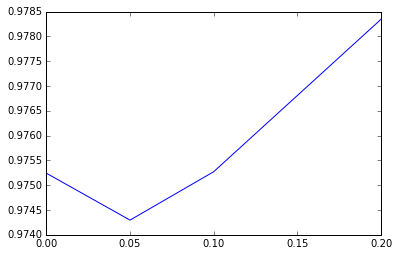

In [109]:
plt.plot([0.,0.05,0.1,0.2], AUC_0)

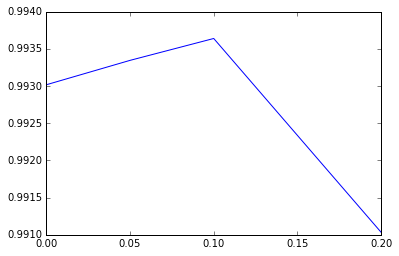

In [110]:
plt.plot([0.,0.05,0.1,0.2], AUC_1)

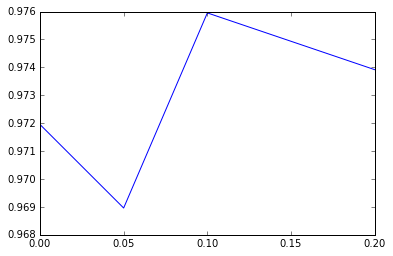

In [111]:
plt.plot([0.,0.05,0.1,0.2], AUC_2)